In [ ]:
# Importar drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install dependencies
#!pip install albumentations==0.4.6
!pip install albumentations
!pip install pycocotools --quiet

# Clone TorchVision repo and copy helper files
!git clone https://github.com/pytorch/vision.git
%cd vision
!git checkout v0.3.0
%cd ..
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'vision'...
remote: Enumerating objects: 250203, done.
remote: Counting objects: 100% (2886/2886), done.
remote: Compressing objects: 100% (254/254), done.
remote: Total 250203 (delta 2666), reused 2806 (delta 2627), pack-reused 247317
Receiving objects: 100% (250203/250203), 503.83 MiB | 39.63 MiB/s, done.
Resolving deltas: 100% (227564/227564), done.
/content/vision
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084d version check against PyTorch's CUDA version
/content


In [ ]:
# basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd

# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# helper libraries
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


# Importar json con etiquetas

In [ ]:
# importing the module
import json

# Opening JSON file
with open('/content/drive/MyDrive/Falabella/dict_bbox_p1_cf.json') as json_file:
    dict_data = json.load(json_file)

In [ ]:
# revisar
dict_data

{'14832_149048123351.png': {'area': [],
  'boxes': [],
  'height': 0.0,
  'image_id': '14832_149048123351.png',
  'iscrowd': [],
  'labels': [],
  'width': 0.0},
 '462_146002385191.png': {'area': [8176.0],
  'boxes': [[64.0, 97.0, 176.0, 170.0]],
  'height': 260.0,
  'image_id': '462_146002385191.png',
  'iscrowd': [0.0],
  'labels': [1],
  'width': 195.0},
 '898_149042996185.png': {'area': [17850.0],
  'boxes': [[0.0, 74.0, 119.0, 224.0]],
  'height': 258.0,
  'image_id': '898_149042996185.png',
  'iscrowd': [0.0],
  'labels': [1],
  'width': 119.0},
 '16862_149062566323.png': {'area': [],
  'boxes': [],
  'height': 0.0,
  'image_id': '16862_149062566323.png',
  'iscrowd': [],
  'labels': [],
  'width': 0.0},
 '15590_149062112712.png': {'area': [],
  'boxes': [],
  'height': 0.0,
  'image_id': '15590_149062112712.png',
  'iscrowd': [],
  'labels': [],
  'width': 0.0},
 '13615_149046653127.png': {'area': [],
  'boxes': [],
  'height': 0.0,
  'image_id': '13615_149046653127.png',
  'isc

In [ ]:
# revisar
len(dict_data)

7631

# Definir clase

In [ ]:
from skimage import io
class PhotosLabelsDataset_od(torch.utils.data.Dataset):
    """Photos labels dataset."""

    def __init__(self, dictionary, root_dir, transforms=None):
        """
        Args:
            xlsx_file (string): Path to the xlsx file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Boolean that indicates
            a transformation or not.
        """
        self.dict_values = list(dictionary.values())
        self.root_dir = root_dir
        self.transforms = transforms
        #self.width = width
        #self.height = height


    def __len__(self):
        return len(self.dict_values)

    def __getitem__(self, idx):

        #print(idx)
        dict_values = self.dict_values
        #img_name = dict_values[idx]['image_id'] + '.png'
        img_name = dict_values[idx]['image_id']
        #print(img_name)

        image_path = os.path.join(self.root_dir, img_name)

        # reading the images and converting them to correct size and color
        #img = cv2.imread(image_path)
        #img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        #img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        #img_res /= 255.0

        image =io.imread(image_path)

        # Diccionario label
        target = {}

        boxes = dict_values[idx]['boxes']
        num_box = len(boxes)
        if num_box>0:
          boxes = torch.as_tensor(boxes, dtype=torch.float32)
        else:
          #negative example, ref: https://github.com/pytorch/vision/issues/2144
          boxes = torch.zeros((0, 4), dtype=torch.float32)

        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_box,), dtype=torch.int64)

        labels = torch.ones((num_box,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        #print(image_id)
        #print('boxes: ', boxes)
        #print('height: ', dict_values[idx]['height'])
        #print('width: ', dict_values[idx]['width'])
        #print('height: ', image.shape)
        #print('width: ', dict_values[idx]['width'])

        if self.transforms:
          sample = self.transforms(image = image,
                                bboxes = target["boxes"],
                                labels = labels)
          image = sample['image']
          #print(len(sample['bboxes']))
          if len(sample['bboxes']) == 0 :
            target['boxes'] = torch.zeros((0, 4), dtype=torch.float32)

          else:
            target['boxes'] = torch.Tensor(sample['bboxes'])

          #print(target['boxes'].shape)
          #print(image)
          #print(image.float().div(255))
          image = image.float().div(255)

        return image, target

In [ ]:
# check dataset
path_fotografias = '/content/drive/MyDrive/Falabella/fotografias1y2'
dataset = PhotosLabelsDataset_od(dictionary = dict_data, root_dir = path_fotografias, transforms=None)
print('Length of dataset:', len(dataset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = dataset[325]
print('Image shape:', img.shape)
print('Label example:', target)

Length of dataset: 7631 

Image shape: (258, 193, 3)
Label example: {'boxes': tensor([[ 50.,  26., 123.,  61.],
        [ 39.,  44., 183., 219.]]), 'labels': tensor([1, 1]), 'area': tensor([ 2555., 25200.]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([325])}


In [1]:
# Function to visualize bounding boxes in the image
def plot_img_bbox(img, target):
  # plot the image and bboxes
  # Bounding boxes are defined as follows: x-min y-min x-max y-max
  #img = img.permute(1, 2, 0)
  fig, a = plt.subplots(1,1)
  fig.set_size_inches(5,5)

  a.imshow(img)
  for box in (target['boxes']):
    x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = patches.Rectangle(
      (x, y),
      width, height,
      linewidth = 2,
      edgecolor = 'r',
      facecolor = 'none'
    )
    # Draw the bounding box on top of the image
    a.add_patch(rect)

  #img_name = str(target['image_id'].item()) + str('.jpg')
  #image_path = os.path.join('/content/bbox_test', img_name)
  #plt.savefig(image_path)
  plt.show()

# plotting the image with bboxes. Feel free to change the index
#img, target = dataset[101]
#plot_img_bbox(img, target)


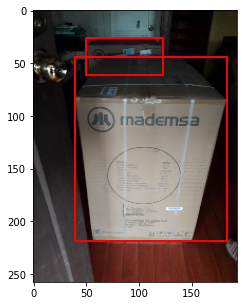

{'boxes': tensor([[ 50.,  26., 123.,  61.],
        [ 39.,  44., 183., 219.]]), 'labels': tensor([1, 1]), 'area': tensor([ 2555., 25200.]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([325])}


In [ ]:
img, target = dataset[325]
plot_img_bbox(img, target)
print(target)

In [ ]:
# Send train=True for training transforms and False for val/test transforms
def get_transform(train):
  if train:
    return A.Compose(
        [
            A.Resize (480, 480),
         A.HorizontalFlip(0.5),
         # ToTensorV2 converts image to pytorch tensor without div by 255
         ToTensorV2(p=1.0)
         ],
         bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
         )
  else:
    return A.Compose(
        [
            A.Resize (480, 480),
         ToTensorV2(p=1.0)
         ],
         bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
         )

In [ ]:
# Send train=True for training transforms and False for val/test transforms
def get_transform(train):
  if train:
    return A.Compose(
        [
            A.Resize (480, 480),
         A.RandomCrop(width=450, height=450),
         A.HorizontalFlip(0.5),
         A.VerticalFlip(0.5),
         A.RandomBrightnessContrast(p=0.5),
         # ToTensorV2 converts image to pytorch tensor without div by 255
         ToTensorV2(p=1.0)
         ],
         bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
         )
  else:
    return A.Compose(
        [
         ToTensorV2(p=1.0)
         ],
         bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
         )

In [ ]:
# separar diccionario en train y test antes de generar el dataset
from sklearn.model_selection import train_test_split

rs = 0
s = pd.Series(dict_data)
train_data , test_data  = [i.to_dict() for i in train_test_split(s, train_size=0.8, random_state=rs)]

# SOLO PARA TESTEO
#train_data , test_data  = [i.to_dict() for i in train_test_split(s, train_size=0.025, random_state=rs)]
#s = pd.Series(train_data)
#train_data , test_data  = [i.to_dict() for i in train_test_split(s, train_size=0.8, random_state=rs)]

print('train: ', len(train_data))
print('test: ', len(test_data))

train:  6104
test:  1527


In [ ]:
def labels_quantity(dic):
  positive = 0
  negative = 0
  for i in dic:
    if dic[i]['labels']:
      positive+=1
    else:
      negative+=1
  return positive, negative

In [ ]:
p_train, n_train = labels_quantity(train_data)
p_test, n_test = labels_quantity(test_data)

print('p_train: ', p_train, ' ', 'n_train', n_train)
print('p_test: ', p_test, ' ', 'n_test', n_test)

p_train:  3370   n_train 2734
p_test:  837   n_test 690


In [ ]:
# use our dataset and defined transformations
path_fotografias = '/content/drive/MyDrive/Falabella/fotografias1y2'
train_set = PhotosLabelsDataset_od(dictionary = train_data, root_dir = path_fotografias, transforms=get_transform(train=True))
test_set = PhotosLabelsDataset_od(dictionary = test_data, root_dir = path_fotografias, transforms=get_transform(train=False))

In [ ]:
trainloader = torch.utils.data.DataLoader(train_set, batch_size=10,
                        shuffle=True, num_workers=4,
                         collate_fn=utils.collate_fn,)
testloader = torch.utils.data.DataLoader(test_set, batch_size=10,
                        shuffle=True, num_workers=4,
                        collate_fn=utils.collate_fn,)

In [ ]:
def get_object_detection_model(num_classes):
  # load a model pre-trained on COCO
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  # get number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  return model

### eval_forward y evaluate_loss para calcular perdidas
sacado de https://stackoverflow.com/questions/71288513/how-can-i-determine-validation-loss-for-faster-rcnn-pytorch

In [ ]:
from typing import Tuple, List, Dict, Optional
import torch
from torch import Tensor
from collections import OrderedDict
from torchvision.models.detection.roi_heads import fastrcnn_loss
from torchvision.models.detection.rpn import concat_box_prediction_layers
def eval_forward(model, images, targets):
    # type: (List[Tensor], Optional[List[Dict[str, Tensor]]]) -> Tuple[Dict[str, Tensor], List[Dict[str, Tensor]]]
    """
    Args:
        images (list[Tensor]): images to be processed
        targets (list[Dict[str, Tensor]]): ground-truth boxes present in the image (optional)
    Returns:
        result (list[BoxList] or dict[Tensor]): the output from the model.
            It returns list[BoxList] contains additional fields
            like `scores`, `labels` and `mask` (for Mask R-CNN models).
    """
    model.eval()

    original_image_sizes: List[Tuple[int, int]] = []
    for img in images:
        val = img.shape[-2:]
        assert len(val) == 2
        original_image_sizes.append((val[0], val[1]))

    images, targets = model.transform(images, targets)

    # Check for degenerate boxes
    # TODO: Move this to a function
    if targets is not None:
        for target_idx, target in enumerate(targets):
            boxes = target["boxes"]
            degenerate_boxes = boxes[:, 2:] <= boxes[:, :2]
            if degenerate_boxes.any():
                # print the first degenerate box
                bb_idx = torch.where(degenerate_boxes.any(dim=1))[0][0]
                degen_bb: List[float] = boxes[bb_idx].tolist()
                raise ValueError(
                    "All bounding boxes should have positive height and width."
                    f" Found invalid box {degen_bb} for target at index {target_idx}."
                )

    features = model.backbone(images.tensors)
    if isinstance(features, torch.Tensor):
        features = OrderedDict([("0", features)])
    model.rpn.training=True
    #model.roi_heads.training=True


    #####proposals, proposal_losses = model.rpn(images, features, targets)
    features_rpn = list(features.values())
    objectness, pred_bbox_deltas = model.rpn.head(features_rpn)
    anchors = model.rpn.anchor_generator(images, features_rpn)

    num_images = len(anchors)
    num_anchors_per_level_shape_tensors = [o[0].shape for o in objectness]
    num_anchors_per_level = [s[0] * s[1] * s[2] for s in num_anchors_per_level_shape_tensors]
    objectness, pred_bbox_deltas = concat_box_prediction_layers(objectness, pred_bbox_deltas)
    # apply pred_bbox_deltas to anchors to obtain the decoded proposals
    # note that we detach the deltas because Faster R-CNN do not backprop through
    # the proposals
    proposals = model.rpn.box_coder.decode(pred_bbox_deltas.detach(), anchors)
    proposals = proposals.view(num_images, -1, 4)
    proposals, scores = model.rpn.filter_proposals(proposals, objectness, images.image_sizes, num_anchors_per_level)

    proposal_losses = {}
    assert targets is not None
    labels, matched_gt_boxes = model.rpn.assign_targets_to_anchors(anchors, targets)
    regression_targets = model.rpn.box_coder.encode(matched_gt_boxes, anchors)
    loss_objectness, loss_rpn_box_reg = model.rpn.compute_loss(
        objectness, pred_bbox_deltas, labels, regression_targets
    )
    proposal_losses = {
        "loss_objectness": loss_objectness,
        "loss_rpn_box_reg": loss_rpn_box_reg,
    }

    #####detections, detector_losses = model.roi_heads(features, proposals, images.image_sizes, targets)
    image_shapes = images.image_sizes
    proposals, matched_idxs, labels, regression_targets = model.roi_heads.select_training_samples(proposals, targets)
    box_features = model.roi_heads.box_roi_pool(features, proposals, image_shapes)
    box_features = model.roi_heads.box_head(box_features)
    class_logits, box_regression = model.roi_heads.box_predictor(box_features)

    result: List[Dict[str, torch.Tensor]] = []
    detector_losses = {}
    loss_classifier, loss_box_reg = fastrcnn_loss(class_logits, box_regression, labels, regression_targets)
    detector_losses = {"loss_classifier": loss_classifier, "loss_box_reg": loss_box_reg}
    boxes, scores, labels = model.roi_heads.postprocess_detections(class_logits, box_regression, proposals, image_shapes)
    num_images = len(boxes)
    for i in range(num_images):
        result.append(
            {
                "boxes": boxes[i],
                "labels": labels[i],
                "scores": scores[i],
            }
        )
    detections = result
    detections = model.transform.postprocess(detections, images.image_sizes, original_image_sizes)  # type: ignore[operator]
    model.rpn.training=False
    model.roi_heads.training=False
    losses = {}
    losses.update(detector_losses)
    losses.update(proposal_losses)
    return losses, detections

In [ ]:
#I determine validation loss by looking at the losses dictionary,
#sum all of these losses, and at the end average them by the length of the dataloader
def evaluate_loss(model, data_loader, device):
    val_loss = 0
    with torch.no_grad():
      for images, targets in data_loader:
          images = list(image.to(device) for image in images)
          targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
          losses_dict, detections = eval_forward(model, images, targets)

          losses = sum(loss for loss in losses_dict.values())

          val_loss += losses

    validation_loss = val_loss/ len(data_loader)
    return validation_loss

### función para matriz de confusión

obtenido de https://github.com/kaanakan/object_detection_confusion_matrix

In [ ]:
# Clone repo
!git clone https://github.com/kaanakan/object_detection_confusion_matrix

Cloning into 'object_detection_confusion_matrix'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 53 (delta 22), reused 18 (delta 7), pack-reused 0
Unpacking objects: 100% (53/53), done.


In [ ]:
from object_detection_confusion_matrix.confusion_matrix import ConfusionMatrix

In [ ]:
conf_mat = ConfusionMatrix(num_classes = 2, CONF_THRESHOLD = 0.5, IOU_THRESHOLD = 0.5)

### entrenamiento

In [ ]:
# train on gpu if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2 # one class (class 0) is dedicated to the "background"

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(
  optimizer,
  step_size=3,
  gamma=0.1
)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
# training for 5 epochs
num_epochs = 100
#PATH = './model_sf.pth'
PATH = '/content/drive/MyDrive/Falabella/model_cf0.pth'

# perdida de validación antes de cada epoca
validation_loss_ini = 1000
# limite de epocas en que aumenta la pérdida de validación
epochs_limit = 2
# numero de epocas en que aumenta la perdida de validación y
# hay que terminar el entrenamiento
epochs = 0
# listas vacias para almacenar perdidas
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    epocas = epoch
    # training for one epoch
    train_one_epoch(model, optimizer, trainloader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()

    # new function that determines training and validation loss
    training_loss = evaluate_loss(model, trainloader, device=device)
    # guardar perdida en lista
    train_losses.append(training_loss)
    print('training_loss:', training_loss)

    validation_loss  = evaluate_loss(model, testloader, device=device)
    # guardar perdida en lista
    val_losses.append(validation_loss)
    print('validation_loss:', validation_loss)


    # early stopping
    if validation_loss <= validation_loss_ini:
      # se guarda el modelo
      torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'validation loss': validation_loss,
            }, PATH)
      # se actualiza validation_loss
      validation_loss_ini = validation_loss
      # se actualizan epocas
      epochs = 0

    elif validation_loss > validation_loss_ini and epochs < epochs_limit:
      # se termina entrenamiento
      epochs += 1

    else:
      # se termina entrenamiento
      break

    print(epochs)
    # evaluate on the test dataset
    evaluate(model, testloader, device=device)

Epoch: [0]  [  0/611]  eta: 1:58:52  lr: 0.000013  loss: 0.5970 (0.5970)  loss_classifier: 0.4401 (0.4401)  loss_box_reg: 0.1300 (0.1300)  loss_objectness: 0.0191 (0.0191)  loss_rpn_box_reg: 0.0078 (0.0078)  time: 11.6730  data: 2.4665  max mem: 8203
Epoch: [0]  [ 10/611]  eta: 0:26:02  lr: 0.000095  loss: 0.5109 (0.5532)  loss_classifier: 0.4040 (0.3932)  loss_box_reg: 0.0871 (0.0908)  loss_objectness: 0.0105 (0.0551)  loss_rpn_box_reg: 0.0041 (0.0141)  time: 2.6003  data: 0.2512  max mem: 8470
Epoch: [0]  [ 20/611]  eta: 0:21:26  lr: 0.000177  loss: 0.4038 (0.4327)  loss_classifier: 0.2741 (0.2921)  loss_box_reg: 0.0857 (0.0908)  loss_objectness: 0.0094 (0.0389)  loss_rpn_box_reg: 0.0042 (0.0108)  time: 1.7014  data: 0.0298  max mem: 8470
Epoch: [0]  [ 30/611]  eta: 0:19:39  lr: 0.000259  loss: 0.2234 (0.3626)  loss_classifier: 0.1113 (0.2304)  loss_box_reg: 0.0892 (0.0933)  loss_objectness: 0.0078 (0.0304)  loss_rpn_box_reg: 0.0042 (0.0086)  time: 1.7168  data: 0.0296  max mem: 8470

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# training and validation loss
mpl.style.use('seaborn')
plt.plot(epocas, train_losses, 'teal', label='Training loss')
plt.plot(epocas, val_losses, 'orange', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### confusion matrix

conf_mat.process_batch(preds, gt_boxes) where preds are predictions made by model, [N, 6] x1, y1, x2, y2, confidence, class and gt_boxes are the ground truth labels, [M, 4] x1, y1, x2, y2, class.

In [ ]:
for _, batch in enumerate(testloader):
  x_test , y_test = batch
  print(y_test)

({'boxes': tensor([[  0.0000, 186.6667, 302.7273, 480.0000]]), 'labels': tensor([1]), 'area': tensor([15873.]), 'iscrowd': tensor([0]), 'image_id': tensor([13])}, {'boxes': tensor([[220.8000,   0.0000, 480.0000, 480.0000]]), 'labels': tensor([1]), 'area': tensor([25245.]), 'iscrowd': tensor([0]), 'image_id': tensor([17])}, {'boxes': tensor([], size=(0, 4)), 'labels': tensor([], dtype=torch.int64), 'area': tensor([]), 'iscrowd': tensor([], dtype=torch.int64), 'image_id': tensor([32])}, {'boxes': tensor([], size=(0, 4)), 'labels': tensor([], dtype=torch.int64), 'area': tensor([]), 'iscrowd': tensor([], dtype=torch.int64), 'image_id': tensor([5])}, {'boxes': tensor([[110.0000,  17.5000, 476.6667, 310.0000]]), 'labels': tensor([1]), 'area': tensor([12870.]), 'iscrowd': tensor([0]), 'image_id': tensor([29])}, {'boxes': tensor([], size=(0, 4)), 'labels': tensor([], dtype=torch.int64), 'area': tensor([]), 'iscrowd': tensor([], dtype=torch.int64), 'image_id': tensor([11])}, {'boxes': tensor([[

In [ ]:
def tuple_of_tensors_to_tensor(tuple_of_tensors):
    return  torch.stack(list(tuple_of_tensors), dim=0)

In [ ]:
device = 'cuda'
model.to(device)
model.eval()              # turn the model to evaluate mode
with torch.no_grad():     # does not calculate gradient
  for _, batch in enumerate(testloader):
    x_test, y_test = batch
    x_test = tuple_of_tensors_to_tensor(x_test)
    preds = model(x_test.to(device))
    print(preds)

[{'boxes': tensor([[151.7386, 113.3724, 440.9408, 442.3056]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0577], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cud

In [ ]:
conf_mat.process_batch(preds, gt_boxes)

In [ ]:
# quickly save our trained model
PATH = './model_sf.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
# Revisar si es que modelo determinar paquete en imagenes full para el caso de model_sf

### Revisión del modelo en algunas imágenes de test

In [ ]:
# cargar modelo
num_classes = 2
#PATH = '/content/drive/MyDrive/Falabella/model_cf0.pth'
PATH = '/content/drive/MyDrive/Falabella/model_cf0_real.pth'
model = get_object_detection_model(num_classes)
#model.load_state_dict(torch.load(PATH))
model_dict = torch.load(PATH)
model.load_state_dict(model_dict['model_state_dict'])
model.eval()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
model_dict

{'epoch': 4,
 'model_state_dict': OrderedDict([('backbone.body.conv1.weight',
               tensor([[[[ 1.3335e-02,  1.4664e-02, -1.5351e-02,  ..., -4.0896e-02,
                          -4.3034e-02, -7.0755e-02],
                         [ 4.1205e-03,  5.8477e-03,  1.4948e-02,  ...,  2.2060e-03,
                          -2.0912e-02, -3.8517e-02],
                         [ 2.2331e-02,  2.3595e-02,  1.6120e-02,  ...,  1.0281e-01,
                           6.2641e-02,  5.1977e-02],
                         ...,
                         [-9.0349e-04,  2.7767e-02, -1.0105e-02,  ..., -1.2722e-01,
                          -7.6604e-02,  7.8453e-03],
                         [ 3.5894e-03,  4.8006e-02,  6.2051e-02,  ...,  2.4267e-02,
                          -3.3662e-02, -1.5709e-02],
                         [-8.0029e-02, -3.2238e-02, -1.7808e-02,  ...,  3.5359e-02,
                           2.2439e-02,  1.7077e-03]],
               
                        [[-1.8452e-02,  1.1415e-02,  

In [ ]:
# Function to visualize bounding boxes in the image
def plot_img_bbox(img, target, axs, i, j, device, prediction = None):
  # plot the image and bboxes
  # Bounding boxes are defined as follows: x-min y-min x-max y-max
  #img = img.permute(1, 2, 0)
  #fig, a = plt.subplots(1,1)
  #fig.set_size_inches(5,5)
  axs[i,j].imshow(img.to(device))

  if prediction:
    boxes = target['boxes'].to(device)
    indice = 0
    for score in target['scores']:
      if score >= 0.5:
        box = boxes[indice]
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle(
          (x, y),
          width, height,
          linewidth = 2,
          edgecolor = 'b',
          facecolor = 'none'
        )
        # Draw the bounding box on top of the image
        axs[i,j].add_patch(rect)
      indice+=1

  else:
    for box in (target['boxes'].to(device)):
      x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
      rect = patches.Rectangle(
        (x, y),
        width, height,
        linewidth = 2,
        edgecolor = 'r',
        facecolor = 'none'
      )
      # Draw the bounding box on top of the image
      axs[i,j].add_patch(rect)

  #img_name = str(target['image_id'].item()) + str('.jpg')
  #image_path = os.path.join('/content/bbox_test', img_name)
  #plt.savefig(image_path)
  #plt.show()

# plotting the image with bboxes. Feel free to change the index
#img, target = dataset[101]
#plot_img_bbox(img, target)

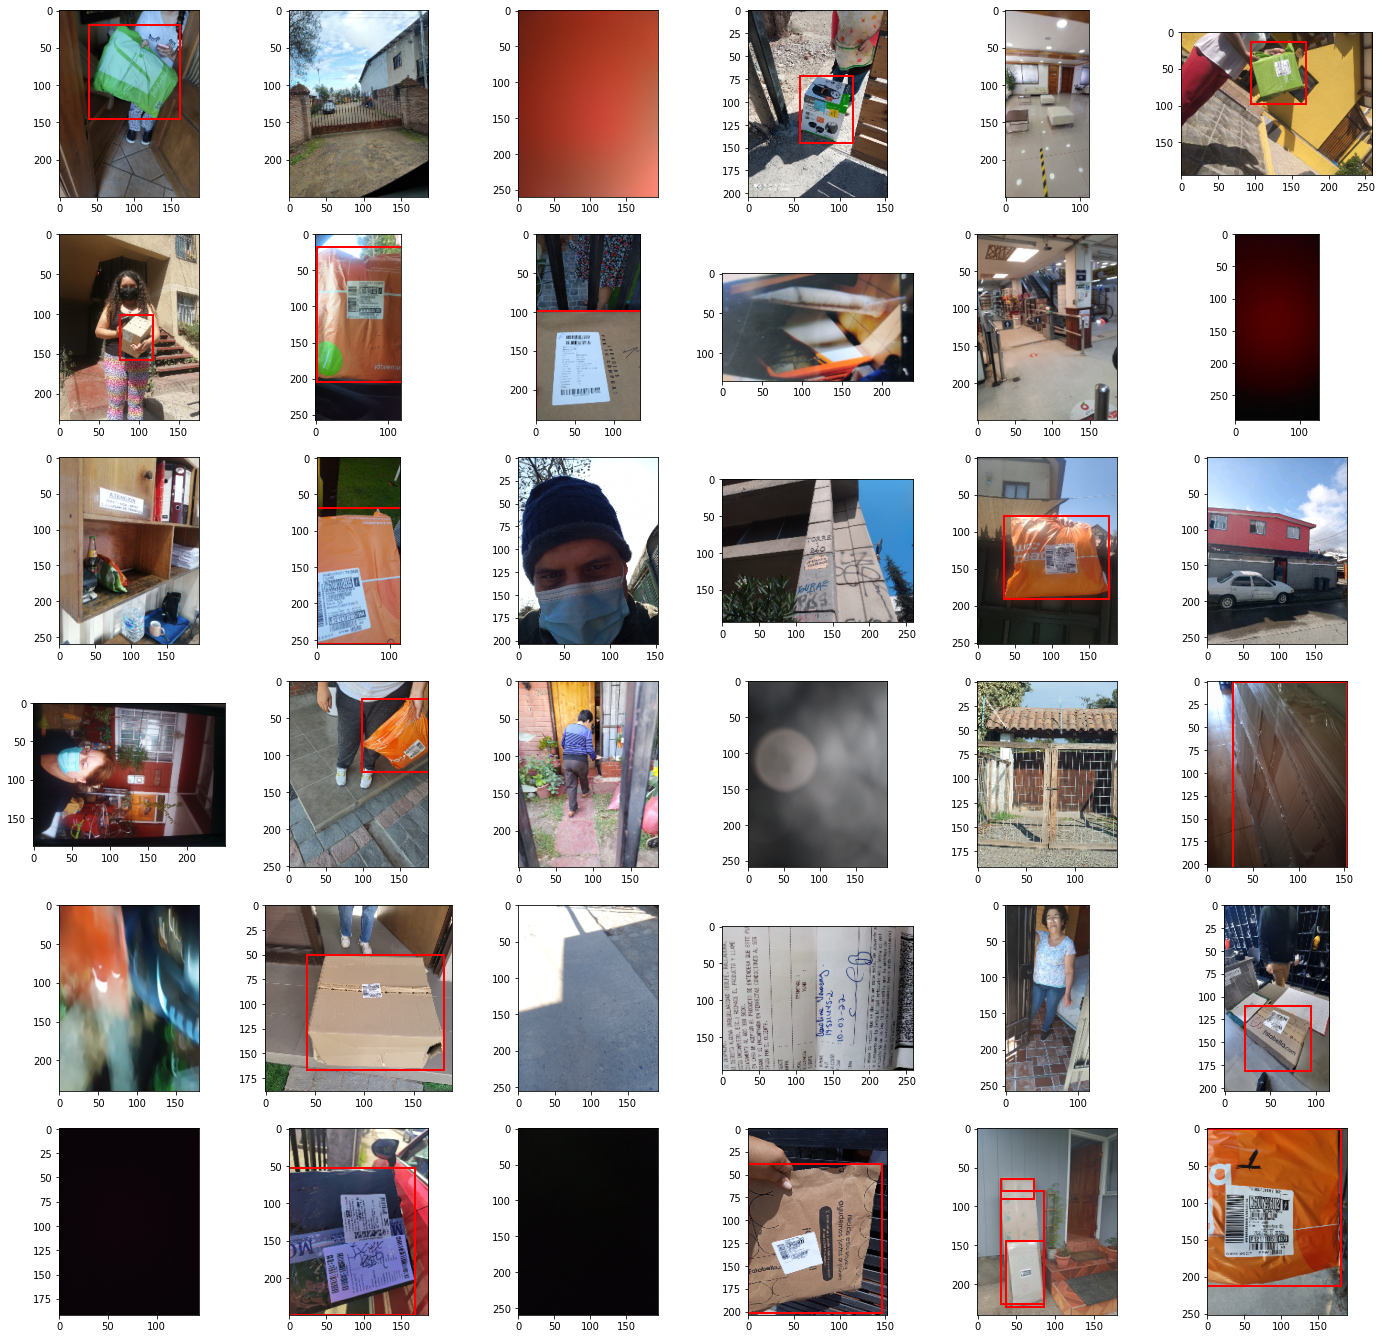

In [ ]:
# Visualización de algunas imagenes
w, h = 6, 6
fig, axs = plt.subplots(h, w, figsize=(4*w,4*h))
idx=0
for i in range(h):
  for j in range(w):
    img, label = test_set[idx]
    idx+=1
    plot_img_bbox(img.permute(1,2,0), label, axs, i, j, 'cpu')

In [ ]:
device = 'cuda'
model.to(device)
model.eval()              # turn the model to evaluate mode
with torch.no_grad():     # does not calculate gradient
  img, _ = test_set[23]
  prediction = model([img.to(device)])
  print(prediction)

[{'boxes': tensor([[ 22.7371,   0.0000, 152.9362, 196.6934]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.6697], device='cuda:0')}]


In [ ]:
prediction[0]['boxes'][0]

tensor([ 91.5906,  29.6698, 171.1227, 108.2319], device='cuda:0')

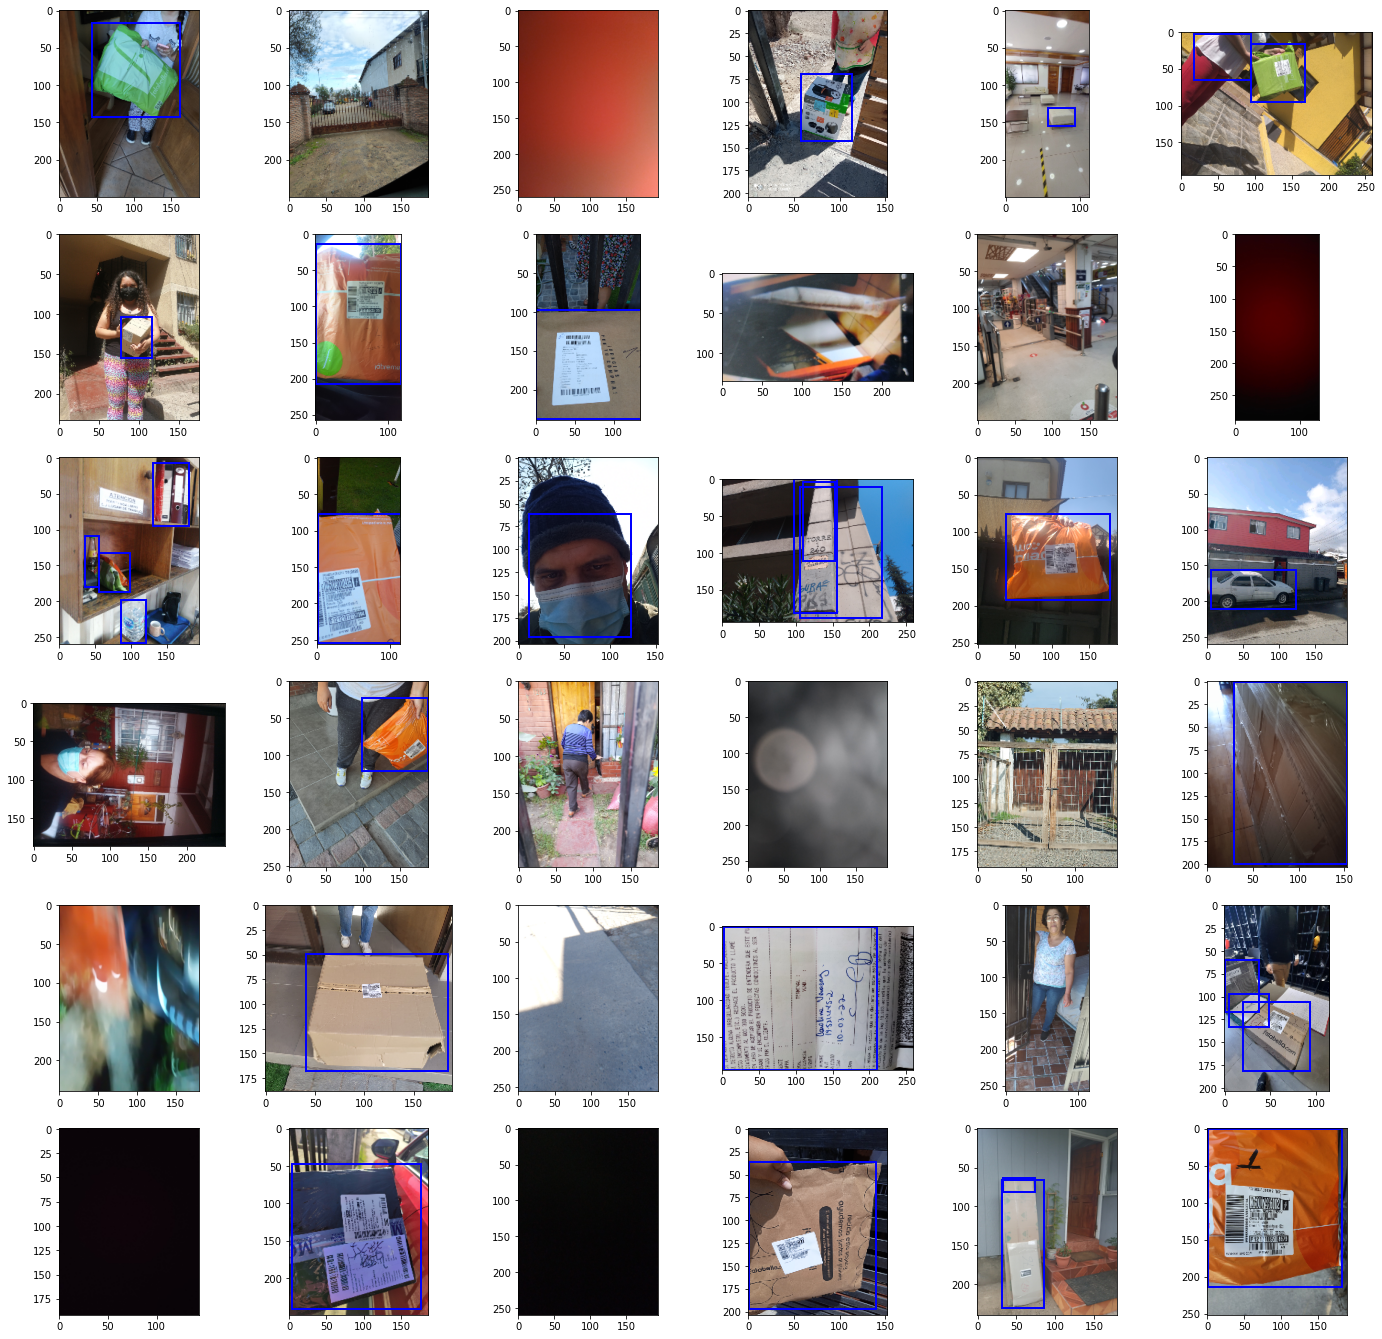

In [ ]:
# Visualización de predicciones
w, h = 6, 6
fig, axs = plt.subplots(h, w, figsize=(4*w,4*h))
idx=0
device = 'cuda'
model.to(device)
model.eval()              # turn the model to evaluate mode
with torch.no_grad():     # does not calculate gradient
  for i in range(h):
    for j in range(w):
      img, _ = test_set[idx]
      prediction = model([img.to(device)])
      idx+=1
      plot_img_bbox(img.permute(1,2,0), prediction[0], axs, i, j, 'cpu', True)

### prueba con 1000_test

* por facilidad ir de uno a uno
por imagenes en carpeta

aplicar transformacion a la imagen

predecir con el modelo

obtener etiqueta de clase del modelo

comparar con lo que se tiene en el excel
(buscar por id)

si coincide sumar 1 al accuracy

si no coincide pasar

luego dividir por todo el largo de la carpeta

In [ ]:
# función para calcular accuracy 1:1
import os
from skimage import io, transform

def od_acc_1000_test(model, path_images, path_xlsx, device = 'cuda'):
  acc = 0
  df = pd.read_excel(path_xlsx)
  model.to(device)
  model.eval()              # turn the model to evaluate mode
  count = 0
  y_test = []
  y_pred = []
  aciertos = 0
  with torch.no_grad():
    for img_name in os.listdir(path_images):
      full_img_name = os.path.join(path_images, img_name)
      image =io.imread(full_img_name)
      t_img = transform.resize(image, (480, 480))
      t_img = torch.Tensor(t_img).permute(2,0,1).to(device)
      prediction = model([t_img])
      if prediction[0]['labels'].shape[0] > 0 and max(prediction[0]['scores'])>= 0.5:
      #if prediction[0]['labels'].shape[0] > 0:
        pred_class = 1
      else:
        pred_class = 0
      y_pred.append(pred_class)
      indice = int(img_name.split('.')[0])
      true_class = df.loc[indice]['Producto']
      y_test.append(true_class)
      if pred_class == true_class:
        aciertos += 1
      else:
        pass
      count+=1
    acc = aciertos/count

    return acc, y_test, y_pred

In [ ]:
path_images = '/content/drive/MyDrive/Falabella/test_1000_imagenes/imagenes'
path_xlsx= '/content/drive/MyDrive/Falabella/test_1000_imagenes/etiquetado ML.xlsx'
od_acc, y_test_list, y_pred_list= od_acc_1000_test(model, path_images, path_xlsx, device = 'cuda')

In [ ]:
print('acc: ', od_acc)

acc:  0.8990825688073395


[[163  47]
 [ 41 621]]
accuracy: 0.8990825688073395 recall: 0.9296407185628742 precision: 0.9380664652567976 F1: 0.9338345864661655


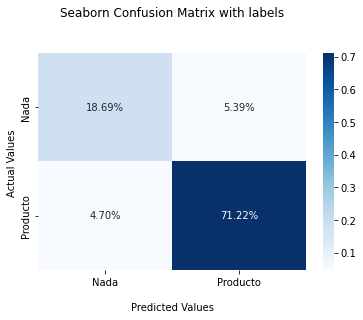

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
y_test = np.array(y_test_list)
y_pred = np.array(y_pred_list)
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
accuracy = (cf_matrix[0][0]+cf_matrix[1][1])/(cf_matrix[0][0] + cf_matrix[0][1] + cf_matrix[1][0]+cf_matrix[1][1])
recall = cf_matrix[1][1]/(cf_matrix[1][1]+cf_matrix[0][1])
precision = cf_matrix[1][1]/(cf_matrix[1][1]+cf_matrix[1][0])
F1 = 2*recall*precision/(recall + precision)
print('accuracy:', accuracy, 'recall:', recall, 'precision:', precision, 'F1:', F1)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Nada','Producto'])
ax.yaxis.set_ticklabels(['Nada','Producto'])

## Display the visualization of the Confusion Matrix.
plt.show()